In [53]:
pip install contextily --quiet

Note: you may need to restart the kernel to use updated packages.


In [1]:
import rasterstats
from rasterstats import zonal_stats
import rasterio
import rioxarray as rxr
from rasterio.plot import show
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as cx

In [2]:
spatial_path = "/Users/markos98/aquasteady_research/data/spatial/"
shape_path = "/Users/markos98/aquasteady_research/data/spatial/CA_shapefiles/"
raw_path = "/Users/markos98/aquasteady_research/data/raw/"

In [3]:
with rasterio.open(spatial_path + "california.tif") as src:
    spi_data = src.read(1)  
    bounds = src.bounds     
    crs = src.crs

In [4]:
drought = spatial_path + "california.tif"

In [5]:
CA_watersheds = gpd.read_file(shape_path + "WBDHU6.shp")
CA_watersheds = CA_watersheds.to_crs(crs)  # Match CRS to SPI data

In [6]:
convex_hull = CA_watersheds[['geometry']].dissolve().convex_hull

In [7]:
convex_hull = gpd.GeoDataFrame(geometry=convex_hull)

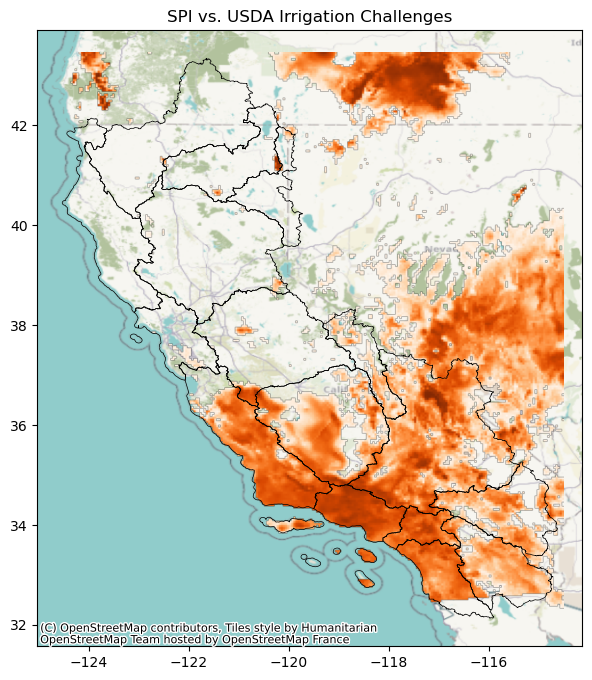

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))

# Overlay watershed boundaries
CA_watersheds.boundary.plot(ax=ax, linewidth=0.5, color="black")

# convex_hull.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2, linestyle='--', label='Convex Hull')

cx.add_basemap(ax, crs = CA_watersheds.crs.to_string())

show(spi_data, ax=ax, transform=src.transform, cmap="Oranges", alpha=1.0)

# Add USDA irrigation data (if available)
# Example: Color watersheds by irrigation acres
# CA_watersheds.plot(ax=ax, column="Irrigated_Acres", legend=True, alpha=0.3)

plt.title("SPI ")
plt.show()

In [37]:
tif_path = spatial_path + "california.tif"  # Replace with your filename
watershed_path = shape_path + "WBDHU6.shp"  # Path to watershed shapefile

In [14]:
spi_stats = rasterstats.zonal_stats(
    spi_data, CA_watersheds, stats=["mean"], geojson_out=True
)

TypeError: invalid path or file:                                      tnmid  \
0   {9261C4BC-9E9B-484A-A82A-34188DD62223}   
1   {E1CF9C3A-D2D4-45B7-893C-74385C35D324}   
2   {98E70FA8-71E6-4D5E-9531-E997720D503B}   
3   {7C49260F-5D97-47FC-B3EE-53AA58128931}   
4   {4D8BD540-3B8B-4D95-995F-422E9B937BA2}   
5   {93FD9EF2-FE24-40C2-B6CE-BCA497EB2F50}   
6   {912C294F-9DB3-482B-95F9-BBA0396A7353}   
7   {EDF88237-DA4E-4F50-9CF7-DC9AC8F2AAE4}   
8   {EC5C66B8-BFCD-425D-BDBB-CEE6F8C3FC6A}   
9   {DD65F514-50C2-421B-BCD3-9B9877C04653}   
10  {F26FDAD1-B4ED-4D49-9473-4DDE6820E23A}   
11  {150932B0-CE4F-46B4-A3B7-29468A698144}   
12  {BE753F72-524E-45D9-A5EE-CE41BA5D90A9}   
13  {C7AD4655-6535-43A8-8E11-6F5A55DD8963}   
14  {2DFCC869-2C3C-4DF0-8EC0-6E7456B1A37D}   
15  {AF8ABA71-5E08-4490-A334-9010FB0B328B}   

                                metasource                        sourcedata  \
0   {31AC21ED-1551-431B-963A-63D44B9887E8}                              None   
1   {B9A0B744-98EC-42A3-8BF3-4F211A797F1E}                              None   
2   {93C374CC-EFFC-4F80-B73B-B02CB768ABCE}                              None   
3   {1FF46025-874C-4D4B-BD40-702A6B62DC21}                              None   
4   {52E8C095-D009-4739-A081-3EBDDA0B550D}                              None   
5   {511D2AC8-11BA-45FC-AB98-F69D693D4C44}  Watershed Boundary Dataset (WBD)   
6   {511D2AC8-11BA-45FC-AB98-F69D693D4C44}  Watershed Boundary Dataset (WBD)   
7   {511D2AC8-11BA-45FC-AB98-F69D693D4C44}  Watershed Boundary Dataset (WBD)   
8   {511D2AC8-11BA-45FC-AB98-F69D693D4C44}  Watershed Boundary Dataset (WBD)   
9   {511D2AC8-11BA-45FC-AB98-F69D693D4C44}  Watershed Boundary Dataset (WBD)   
10  {511D2AC8-11BA-45FC-AB98-F69D693D4C44}  Watershed Boundary Dataset (WBD)   
11  {511D2AC8-11BA-45FC-AB98-F69D693D4C44}  Watershed Boundary Dataset (WBD)   
12  {511D2AC8-11BA-45FC-AB98-F69D693D4C44}  Watershed Boundary Dataset (WBD)   
13  {511D2AC8-11BA-45FC-AB98-F69D693D4C44}  Watershed Boundary Dataset (WBD)   
14  {511D2AC8-11BA-45FC-AB98-F69D693D4C44}  Watershed Boundary Dataset (WBD)   
15  {511D2AC8-11BA-45FC-AB98-F69D693D4C44}  Watershed Boundary Dataset (WBD)   

                                           sourceorig sourcefeat   loaddate  \
0                              U.S. Geological Survey       None 2022-01-02   
1                              U.S. Geological Survey       None 2022-01-04   
2                              U.S. Geological Survey       None 2022-01-03   
3                              U.S. Geological Survey       None 2022-03-16   
4                              U.S. Geological Survey       None 2022-01-02   
5   Natural Resources and Conservation Service and...       None 2024-08-16   
6   Natural Resources and Conservation Service and...       None 2024-08-16   
7   Natural Resources and Conservation Service and...       None 2024-08-16   
8   Natural Resources and Conservation Service and...       None 2024-08-16   
9   Natural Resources and Conservation Service and...       None 2024-08-16   
10  Natural Resources and Conservation Service and...       None 2024-08-16   
11  Natural Resources and Conservation Service and...       None 2024-08-16   
12  Natural Resources and Conservation Service and...       None 2024-08-16   
13  Natural Resources and Conservation Service and...       None 2024-08-16   
14  Natural Resources and Conservation Service and...       None 2024-08-16   
15  Natural Resources and Conservation Service and...       None 2024-08-16   

        referenceg    areaacres  areasqkm states    huc6  \
0             None   8472484.56  34286.96     CA  180600   
1             None   2913621.09  11791.02  CA,NV  180800   
2             None   3494396.76  14141.33  CA,MX  180703   
3             None   6703510.29  27128.17  CA,OR  180101   
4             None   3587894.84  14519.71     CA  180701   
5           263749   2800166.29  11331.88  CA,NV  180901   
6          1654951   3437208.65  13909.90     CA  180500   
7          1654949   4914813.15  19889.56  CA,OR  180200   
8          1652790   1779076.43   7199.67     CA  180702   
9           248771   5261115.29  21291.00  CA,MX  181002   
10          232405  10127904.92  40986.21     CA  180400   
11          277534  10040760.31  40633.55  CA,OR  180102   
12         1654949  12880011.17  52123.60     CA  180201   
13  1652803,690469  10501344.46  42497.47     CA  180300   
14          246062  15305056.78  61937.42  CA,NV  180902   
15          246062   5673042.45  22958.01     CA  181001   

                           name  shape_Leng  shape_Area  ObjectID  \
0    Central California Coastal         NaN         NaN         1   
1                North Lahontan         NaN         NaN         2   
2      Laguna-San Diego Coastal         NaN         NaN         3   
3   Northern California Coastal         NaN         NaN         4   
4   Ventura-San Gabriel Coastal         NaN         NaN         5   
5              Mono-Owens Lakes         NaN         NaN         6   
6             San Francisco Bay         NaN         NaN         7   
7              Upper Sacramento         NaN         NaN         8   
8                     Santa Ana         NaN         NaN         9   
9                    Salton Sea         NaN         NaN        10   
10                  San Joaquin         NaN         NaN        11   
11                      Klamath         NaN         NaN        12   
12             Lower Sacramento         NaN         NaN        13   
13     Tulare-Buena Vista Lakes         NaN         NaN        14   
14              Northern Mojave         NaN         NaN        15   
15              Southern Mojave         NaN         NaN        16   

                                             geometry  
0   MULTIPOLYGON (((-122.11788 37.25462, -122.1175...  
1   POLYGON ((-120.18351 41.97435, -120.18308 41.9...  
2   POLYGON ((-117.52437 33.71674, -117.52371 33.7...  
3   POLYGON ((-123.9348 42.13416, -123.93415 42.13...  
4   MULTIPOLYGON (((-119.10906 34.82364, -119.1086...  
5   POLYGON ((-118.75943 38.32086, -118.75926 38.3...  
6   MULTIPOLYGON (((-123.01418 37.94333, -123.0148...  
7   POLYGON ((-120.45819 42.43185, -120.45777 42.4...  
8   POLYGON ((-117.56758 34.38448, -117.56734 34.3...  
9   POLYGON ((-116.6235 34.16721, -116.6228 34.166...  
10  POLYGON ((-120.5401 38.75126, -120.53834 38.75...  
11  POLYGON ((-121.6369 43.34029, -121.63714 43.33...  
12  POLYGON ((-122.54119 41.00283, -122.54064 41.0...  
13  POLYGON ((-118.90461 37.20802, -118.90404 37.2...  
14  POLYGON ((-118.14504 37.51503, -118.14491 37.5...  
15  POLYGON ((-115.33797 35.26291, -115.33785 35.2...  

In [46]:
usda = pd.read_csv(raw_path + "USDA_CA.csv")  # Your attached file
merged = gpd.GeoDataFrame.from_features(stats).merge(usda, on="HUC_code")

KeyError: 'geometry'